使用下面的命令打开端口转发，然后在本地使用服务器内核运行jupyter
```
ssh -L 8888:localhost:8888 zjb@`hiServer -pIP`
```
切换到空闲GPU

In [43]:
from fastai.vision.all import *
import torch

print(torch.cuda.is_available())
torch.cuda.set_device(0)

True


In [44]:
#hide
# ! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [45]:
#hide
from fastbook import *
from IPython.display import display,HTML

# Data Munging with fastai's Mid-Level API

We have seen what `Tokenizer` and `Numericalize` do to a collection of texts, and how they're used inside the data block API, which handles those transforms for us directly using the `TextBlock`. But what if we want to only apply one of those transforms, either to see intermediate results or because we have already tokenized texts? More generally, what can we do when the data block API is not flexible enough to accommodate our particular use case? For this, we need to use fastai's *mid-level API* for processing data. The data block API is built on top of that layer, so it will allow you to do everything the data block API does, and much much more.

我们已经看到了`Tokenizer`和`Numericalize`对文本集合的处理方式，以及它们如何在数据块 API 中使用，该 API 直接使用`TextBlock`处理这些转换。但是，如果我们只想应用这些转换中的一个，要么是为了查看中间结果，要么是因为我们已经对文本进行了标记化，我们该怎么办？更一般地说，当数据块 API 不足以满足我们特定用例的需求时，我们需要使用 fastai 的中级 API来处理数据。数据块 API 是建立在该层之上的，因此它将允许您执行数据块 API 所做的一切，以及更多更多。

## Going Deeper into fastai's Layered API

## 深入了解fastai的分层APi

The fastai library is built on a *layered API*. In the very top layer there are *applications* that allow us to train a model in five lines of codes, as we saw in <<chapter_intro>>. In the case of creating `DataLoaders` for a text classifier, for instance, we used the line:

fastai 库构建在*分层 API* 之上。在最顶层有“应用程序”，允许我们用五行代码训练模型，正如我们在<<chapter_intro>>中看到的那样。例如，在为文本分类器创建`DataLoaders`的情况下，我们使用了以下行：

In [46]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')

The factory method `TextDataLoaders.from_folder` is very convenient when your data is arranged the exact same way as the IMDb dataset, but in practice, that often won't be the case. The data block API offers more flexibility. As we saw in the last chapter, we can get the same result with:

当数据的排列方式与 IMDb 数据集完全相同时，工厂方法`TextDataLoaders.from_folder`非常方便，但实际上，情况通常并非如此。数据块 API 提供了更大的灵活性。正如我们在上一章中看到的，我们可以得到相同的结果：

In [47]:
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

But it's sometimes not flexible enough. For debugging purposes, for instance, we might need to apply just parts of the transforms that come with this data block. Or we might want to create a `DataLoaders` for some application that isn't directly supported by fastai. In this section, we'll dig into the pieces that are used inside fastai to implement the data block API. Understanding these will enable you to leverage the power and flexibility of this mid-tier API.

但有时不够灵活。例如，出于调试目的，我们可能只需要应用此数据块附带的部分转换。或者我们可能想为某些 fastai 不直接支持的应用程序创建一个`DataLoaders`。在本节中，我们将深入研究 fastai 内部用于实现数据块 API 的部分。了解这些将使您能够利用这个中间层 API 的强大功能和灵活性。

> note: Mid-Level API: The mid-level API does not only contain functionality for creating `DataLoaders`. It also has the _callback_ system, which allows us to customize the training loop any way we like, and the _general optimizer_. Both will be covered in <<chapter_accel_sgd>>.

> 注意：中级 API：中级 API 不仅包含创建`DataLoaders`的功能。它还具有_回调_系统（允许我们以任何我们喜欢的方式自定义训练循环）和_通用优化器_。两者都将在<<chapter_accel_sgd>>中介绍。

### Transforms

When we studied tokenization and numericalization in the last chapter, we started by grabbing a bunch of texts:

当我们在上一章中研究标记化和数值化时，我们首先抓取了一堆文本：

In [48]:
files = get_text_files(path, folders = ['train', 'test'])
txts = L(o.open().read() for o in files[:2000])

We then showed how to tokenize them with a `Tokenizer`:

然后我们展示了如何使用`Tokenizer`对它们进行标记：

In [49]:
tok = Tokenizer.from_folder(path)
tok.setup(txts)
toks = txts.map(tok)
toks[0]

(#178) ['xxbos','xxmaj','well',',','of','course','not',',','women','are'...]

and how to numericalize, including automatically creating the vocab for our corpus:

以及如何进行数值化，包括自动为我们的语料库创建词汇表：

In [50]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num)
nums[0][:10]

TensorText([  2,   8,  73,  10,  14, 276,  40,  10, 372,  39])

The classes also have a `decode` method. For instance, `Numericalize.decode` gives us back the string tokens:

这些类还有一个`decode`方法。例如，`Numericalize.decode`会将字符串标记返回给我们：

In [51]:
nums_dec = num.decode(nums[0][:10]); nums_dec

(#10) ['xxbos','xxmaj','well',',','of','course','not',',','women','are']

and `Tokenizer.decode` turns this back into a single string (it may not, however, be exactly the same as the original string; this depends on whether the tokenizer is *reversible*, which the default word tokenizer is not at the time we're writing this book):

`Tokenizer.decode`将其转换回一个字符串（但可能不完全与原始字符串相同；这取决于标记器是否是可逆的，在我们撰写本书时，默认的单词标记器不是）：

In [52]:
tok.decode(nums_dec)

'xxbos xxmaj well , of course not , women are'

`decode` is used by fastai's `show_batch` and `show_results`, as well as some other inference methods, to convert predictions and mini-batches into a human-understandable representation.

For each of `tok` or `num` in the preceding example, we created an object, called the `setup` method (which trains the tokenizer if needed for `tok` and creates the vocab for `num`), applied it to our raw texts (by calling the object as a function), and then finally decoded the result back to an understandable representation. These steps are needed for most data preprocessing tasks, so fastai provides a class that encapsulates them. This is the `Transform` class. Both `Tokenize` and `Numericalize` are `Transform`s.

In general, a `Transform` is an object that behaves like a function and has an optional `setup` method that will initialize some inner state (like the vocab inside `num`) and an optional `decode` that will reverse the function (this reversal may not be perfect, as we saw with `tok`).

A good example of `decode` is found in the `Normalize` transform that we saw in <<chapter_sizing_and_tta>>: to be able to plot the images its `decode` method undoes the normalization (i.e., it multiplies by the standard deviation and adds back the mean). On the other hand, data augmentation transforms do not have a `decode` method, since we want to show the effects on images to make sure the data augmentation is working as we want.

A special behavior of `Transform`s is that they always get applied over tuples. In general, our data is always a tuple `(input,target)` (sometimes with more than one input or more than one target). When applying a transform on an item like this, such as `Resize`, we don't want to resize the tuple as a whole; instead, we want to resize the input (if applicable) and the target (if applicable) separately. It's the same for batch transforms that do data augmentation: when the input is an image and the target is a segmentation mask, the transform needs to be applied (the same way) to the input and the target.

We can see this behavior if we pass a tuple of texts to `tok`:

`decode`被 fastai 的`show_batch`和`show_results`以及其他一些推断方法使用，将预测和小批量转换为人类可理解的表示。

在前面的示例中，对于`tok`或`num`，我们创建了一个名为`setup`的对象（如果需要为`tok`训练标记器并为`num`创建词汇表），将其应用于我们的原始文本（通过将对象作为函数调用），然后最终将结果解码回可理解的表示。大多数数据预处理任务都需要这些步骤，因此 fastai 提供了一个封装它们的类。这就是`Transform`类。`Tokenize`和`Numericalize`都是Transform。

一般来说，`Transform`是一个行为类似于函数的对象，它具有一个可选的`setup`方法，用于初始化内部状态（例如`num`内部的词汇表），以及一个可选的`decode`方法，用于反转函数（正如我们在`tok`中看到的那样，这种反转可能不完美）。

`decode` 的一个很好的例子可以在我们在 第七章 中看到的 `Normalize` 转换中找到：为了能够绘制图像，它的 `decode` 方法会撤消归一化（即，乘以标准差并加回均值）。另一方面，数据增强转换没有 `decode` 方法，因为我们希望展示图像上的效果，以确保数据增强按我们的意愿进行工作。

`Transform` 的一个特殊行为是它们总是应用于元组。一般来说，我们的数据总是一个元组 `(input, target)`（有时有多个输入或多个目标）。当对这样的项目应用转换时，例如 `Resize`，我们不希望整个元组被调整大小；相反，我们希望分别调整输入（如果适用）和目标（如果适用）。对于进行数据增强的批处理转换也是一样的：当输入是图像且目标是分割掩模时，需要将转换（以相同的方式）应用于输入和目标。

如果我们将一个文本元组传递给 `tok`，我们可以看到这种行为：

In [53]:
tok((txts[0], txts[1]))

((#178) ['xxbos','xxmaj','well',',','of','course','not',',','women','are'...],
 (#522) ['xxbos','a','xxmaj','compelling','xxmaj','thriller','!','!',',','10'...])

### Writing Your Own Transform

If you want to write a custom transform to apply to your data, the easiest way is to write a function. As you can see in this example, a `Transform` will only be applied to a matching type, if a type is provided (otherwise it will always be applied). In the following code, the `:int` in the function signature means that `f` only gets applied to `int`s. That's why `tfm(2.0)` returns `2.0`, but `tfm(2)` returns `3` here:

如果您想编写一个自定义的转换来应用于您的数据，最简单的方法是编写一个函数。正如您在这个例子中看到的，`Transform` 只会应用于匹配的类型，如果提供了类型（否则，它将始终被应用）。在下面的代码中，函数签名中的 `:int` 表示 `f` 仅应用于 `ints`。这就是为什么 `tfm(2.0)` 返回 `2.0`，但 `tfm(2)` 在这里返回 `3`：

In [54]:
def f(x:int): return x+1
tfm = Transform(f)
tfm(2),tfm(2.0)

(3, 2.0)

Here, `f` is converted to a `Transform` with no `setup` and no `decode` method.

Python has a special syntax for passing a function (like `f`) to another function (or something that behaves like a function, known as a *callable* in Python), called a *decorator*. A decorator is used by prepending a callable with `@` and placing it before a function definition (there are lots of good online tutorials about Python decorators, so take a look at one if this is a new concept for you). The following is identical to the previous code:

在这里，`f` 被转换为一个没有 `setup` 和没有 `decode` 方法的 `Transform`。

Python 有一种特殊的语法，用于将一个函数（如 `f`）传递给另一个函数（或类似函数的东西，在 Python 中称为 `callable`），称为 `decorator`。通过在可调用对象前加上 `@` 并将其放在函数定义之前来使用装饰器（关于 Python 装饰器有很多很好的在线教程，如果这对您来说是一个新概念，请查看其中一个）。以下代码与前面的代码相同：

In [55]:
@Transform
def f(x:int): return x+1
f(2),f(2.0)

(3, 2.0)

If you need either `setup` or `decode`, you will need to subclass `Transform` to implement the actual encoding behavior in `encodes`, then (optionally), the setup behavior in `setups` and the decoding behavior in `decodes`:

如果您需要 `setup` 或 `decode`，您需要对 `Transform` 进行子类化，以在 `encodes` 中实现实际的编码行为，然后（可选）在 `setups` 中实现设置行为和在 `decodes` 中实现解码行为：

In [56]:
class NormalizeMean(Transform):
    def setups(self, items): self.mean = sum(items)/len(items)
    def encodes(self, x): return x-self.mean
    def decodes(self, x): return x+self.mean

Here, `NormalizeMean` will initialize some state during the setup (the mean of all elements passed), then the transformation is to subtract that mean. For decoding purposes, we implement the reverse of that transformation by adding the mean. Here is an example of `NormalizeMean` in action:

在这里，`NormalizeMean` 将在设置期间初始化某个状态（传递的所有元素的平均值）；然后转换是减去该平均值。为了解码目的，我们通过添加平均值来实现该转换的反向。这里是 `NormalizeMean` 的一个示例：

In [57]:
tfm = NormalizeMean()
tfm.setup([1,2,3,4,5])
start = 2
y = tfm(start)
z = tfm.decode(y)
tfm.mean,y,z

(3.0, -1.0, 2.0)

Note that the method called and the method implemented are different, for each of these methods:

```asciidoc
[options="header"]
|======
| Class | To call | To implement
| `nn.Module` (PyTorch) | `()` (i.e., call as function) | `forward`
| `Transform` | `()` | `encodes`
| `Transform` | `decode()` | `decodes`
| `Transform` | `setup()` | `setups`
|======
```

So, for instance, you would never call `setups` directly, but instead would call `setup`. The reason for this is that `setup` does some work before and after calling `setups` for you. To learn more about `Transform`s and how you can use them to implement different behavior depending on the type of the input, be sure to check the tutorials in the fastai docs.

请注意，每个方法的调用和实现是不同的：

| 类 | 调用 | 实现 |
| --- | --- | --- |
| `nn.Module`（PyTorch） | `()`（即，作为函数调用） | `forward` |
| `Transform` | `()` | `encodes` |
| `Transform` | `decode()` | `decodes` |
| `Transform` | `setup()` | `setups` |

因此，例如，您永远不会直接调用 `setups`，而是会调用 `setup`。原因是 `setup` 在为您调用 `setups` 之前和之后做了一些工作。要了解有关 `Transform` 及如何使用它们根据输入类型实现不同行为的更多信息，请务必查看 fastai 文档中的教程。

### Pipeline

To compose several transforms together, fastai provides the `Pipeline` class. We define a `Pipeline` by passing it a list of `Transform`s; it will then compose the transforms inside it. When you call `Pipeline` on an object, it will automatically call the transforms inside, in order:

要将几个转换组合在一起，fastai 提供了 `Pipeline` 类。我们通过向 `Pipeline` 传递一个 `Transform` 列表来定义一个 `Pipeline`；然后它将组合其中的转换。当您在对象上调用 `Pipeline` 时，它将自动按顺序调用其中的转换：

In [58]:
tfms = Pipeline([tok, num])
t = tfms(txts[0]); t[:20]

TensorText([   2,    8,   73,   10,   14,  276,   40,   10,  372,   39, 1986, 1919,   12, 7318,   35,  847,   10,   78,   16, 4539])

And you can call `decode` on the result of your encoding, to get back something you can display and analyze:

您可以对编码结果调用 `decode`，以获取可以显示和分析的内容：

In [59]:
tfms.decode(t)[:100]

'xxbos xxmaj well , of course not , women are overly sensitive and needy on average , which is intere'

The only part that doesn't work the same way as in `Transform` is the setup. To properly set up a `Pipeline` of `Transform`s on some data, you need to use a `TfmdLists`.

`Transform` 中与 `Transform` 不同的部分是设置。要在一些数据上正确设置 `Transform` 的 `Pipeline`，您需要使用 `TfmdLists`。

## TfmdLists and Datasets: Transformed Collections

## TfmdLists 和 Datasets：转换的集合

Your data is usually a set of raw items (like filenames, or rows in a DataFrame) to which you want to apply a succession of transformations. We just saw that a succession of transformations is represented by a `Pipeline` in fastai. The class that groups together this `Pipeline` with your raw items is called `TfmdLists`.

您的数据通常是一组原始项目（如文件名或 DataFrame 中的行），您希望对其应用一系列转换。我们刚刚看到，一系列转换在 fastai 中由`Pipeline`表示。将这个`Pipeline`与您的原始项目组合在一起的类称为`TfmdLists`。

### TfmdLists

Here is the short way of doing the transformation we saw in the previous section:

以下是在前一节中看到的转换的简短方式：

In [60]:
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize])

At initialization, the `TfmdLists` will automatically call the `setup` method of each `Transform` in order, providing them not with the raw items but the items transformed by all the previous `Transform`s in order. We can get the result of our `Pipeline` on any raw element just by indexing into the `TfmdLists`:

在初始化时，`TfmdLists`将自动调用每个`Transform`的`setup`方法，依次提供每个原始项目而不是由所有先前的`Transform`转换的项目。我们可以通过索引到`TfmdLists`中的任何原始元素来获得我们的`Pipeline`的结果：

In [61]:
t = tls[0]; t[:20]

TensorText([    2,     8,    91,    11,    14,   286,    38,    11,   370,    39,  1981,  2558,    12, 14147,    35,   849,    11,    82,    16,  5104])

And the `TfmdLists` knows how to decode for show purposes:

而`TfmdLists`知道如何解码以进行显示：

In [62]:
tls.decode(t)[:100]

'xxbos xxmaj well , of course not , women are overly sensitive and needy on average , which is intere'

In fact, it even has a `show` method:

实际上，它甚至有一个`show`方法：

In [63]:
tls.show(t)

xxbos xxmaj well , of course not , women are overly sensitive and needy on average , which is interestingly portrayed from mother to whore , though not pseudo - artistically , extravagantly , or blatantly dwelt on . xxmaj unlike many of you i have only seen xxmaj la xxmaj maman et xxmaj la xxmaj putain twice . xxmaj as many good films , i noticed my opinion of it improved after a second viewing . xxmaj all that i know is what i have seen and have yet to delve into further exploits until i myself have acquired the dvd . i have yet to figure out precisely why i enjoy this movie so much , but really , what do i care why ? xxmaj though xxmaj i 'm sure i could and will form some wonderful explanation . xxmaj all right , so you may disagree , perhaps it is a bit boring at times , xxmaj i 'm not an expert . xxmaj the blonde reminds me of a lovely xxmaj xxunk .


The `TfmdLists` is named with an "s" because it can handle a training and a validation set with a `splits` argument. You just need to pass the indices of which elements are in the training set, and which are in the validation set:

`TfmdLists`以“s”命名，因为它可以使用`splits`参数处理训练集和验证集。您只需要传递在训练集中的元素的索引和在验证集中的元素的索引：

In [64]:
cut = int(len(files)*0.8)
splits = [list(range(cut)), list(range(cut,len(files)))]
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize], 
                splits=splits)

You can then access them through the `train` and `valid` attributes:

然后可以通过`train`和`valid`属性访问它们：

In [65]:
tls.valid[0][:20]

TensorText([   2,    5,  153,   54,    8, 1304, 4473,    5,  153,   54,   26,    8,    9,  244,   16,   11,  176,   11,   21,   19])

If you have manually written a `Transform` that performs all of your preprocessing at once, turning raw items into a tuple with inputs and targets, then `TfmdLists` is the class you need. You can directly convert it to a `DataLoaders` object with the `dataloaders` method. This is what we will do in our Siamese example later in this chapter.

In general, though, you will have two (or more) parallel pipelines of transforms: one for processing your raw items into inputs and one to process your raw items into targets. For instance, here, the pipeline we defined only processes the raw text into inputs. If we want to do text classification, we also have to process the labels into targets. 

For this we need to do two things. First we take the label name from the parent folder. There is a function, `parent_label`, for this:

如果您手动编写了一个`Transform`，一次执行所有预处理，将原始项目转换为具有输入和目标的元组，那么`TfmdLists`是您需要的类。您可以使用`dataloaders`方法直接将其转换为`DataLoaders`对象。这是我们稍后在本章中将要做的事情。

一般来说，您将有两个（或更多）并行的转换流水线：一个用于将原始项目处理为输入，另一个用于将原始项目处理为目标。例如，在这里，我们定义的流水线仅将原始文本处理为输入。如果我们要进行文本分类，还必须将标签处理为目标。

为此，我们需要做两件事。首先，我们从父文件夹中获取标签名称。有一个名为`parent_label`的函数：

In [66]:
lbls = files.map(parent_label)
lbls

(#50000) ['pos','pos','pos','pos','pos','pos','pos','pos','pos','pos'...]

Then we need a `Transform` that will grab the unique items and build a vocab with them during setup, then transform the string labels into integers when called. fastai provides this for us; it's called `Categorize`:

然后我们需要一个`Transform`，在设置期间将抓取的唯一项目构建为词汇表，然后在调用时将字符串标签转换为整数。fastai 为我们提供了这个；它被称为`Categorize`：

In [67]:
cat = Categorize()
cat.setup(lbls)
cat.vocab, cat(lbls[0])

(['neg', 'pos'], TensorCategory(1))

To do the whole setup automatically on our list of files, we can create a `TfmdLists` as before:

要在我们的文件列表上自动执行整个设置，我们可以像以前一样创建一个`TfmdLists`：

In [68]:
tls_y = TfmdLists(files, [parent_label, Categorize()])
tls_y[0]

TensorCategory(1)

But then we end up with two separate objects for our inputs and targets, which is not what we want. This is where `Datasets` comes to the rescue.

但是然后我们得到了两个分开的对象用于我们的输入和目标，这不是我们想要的。这就是`Datasets`发挥作用的地方。

### Datasets

`Datasets` will apply two (or more) pipelines in parallel to the same raw object and build a tuple with the result. Like `TfmdLists`, it will automatically do the setup for us, and when we index into a `Datasets`, it will return us a tuple with the results of each pipeline:

`Datasets`将并行应用两个（或更多）流水线到相同的原始对象，并构建一个包含结果的元组。与`TfmdLists`一样，它将自动为我们进行设置，当我们索引到`Datasets`时，它将返回一个包含每个流水线结果的元组：

In [69]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms])
x,y = dsets[0]
x[:20],y

(TensorText([    2,     8,    91,    11,    14,   286,    38,    11,   370,    39,  1981,  2558,    12, 14147,    35,   849,    11,    82,    16,  5104]),
 TensorCategory(1))

Like a `TfmdLists`, we can pass along `splits` to a `Datasets` to split our data between training and validation sets:

像`TfmdLists`一样，我们可以将`splits`传递给`Datasets`以在训练和验证集之间拆分我们的数据：

In [70]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms], splits=splits)
x,y = dsets.valid[0]
x[:20],y

(TensorText([   2,    5,  153,   54,    8, 1304, 4473,    5,  153,   54,   26,    8,    9,  244,   16,   11,  176,   11,   21,   19]),
 TensorCategory(0))

It can also decode any processed tuple or show it directly:

它还可以解码任何处理过的元组或直接显示它：

In [71]:
t = dsets.valid[0]
dsets.decode(t)

("xxbos xxrep 3 ! xxmaj spoiler alert xxrep 3 ! \n\n xxmaj the point is , though , that i did n't think this film had an ending xxup to spoil … i only started watching it in the middle , after xxmaj matt had gotten into xxmaj sarah 's body , but then i became fascinated by the bizarreness of the plot , even for a xxmaj channel 5 movie … and could n't possibly see how xxmaj matt xxunk end up happy . xxmaj what about his fiancee ? xxmaj at one stage looked like he was gon na get with his best friend , surely icky and wrong … and then the whole ' oggi oggi oggi ' thing does xxup not xxup work as a touching buddy - buddy catchphrase , tis just ridiculous … so was going ' surely he ca n't just come back to life ? and yet how can he live as a woman ? ' and then the film just got over that by ending and not explaining anything at all xxrep 5 ! xxmaj what 's that about xxrep 3 ? i was so cross , wasted a whole hour of my life for no reason at all xxrep 3 ! :) but was one of the funniest films 

The last step is to convert our `Datasets` object to a `DataLoaders`, which can be done with the `dataloaders` method. Here we need to pass along a special argument to take care of the padding problem (as we saw in the last chapter). This needs to happen just before we batch the elements, so we pass it to `before_batch`: 

最后一步是将我们的`Datasets`对象转换为`DataLoaders`，可以使用`dataloaders`方法完成。在这里，我们需要传递一个特殊参数来解决填充问题（正如我们在前一章中看到的）。这需要在我们批处理元素之前发生，所以我们将其传递给`before_batch`：

In [72]:
dls = dsets.dataloaders(bs=64, before_batch=pad_input)

`dataloaders` directly calls `DataLoader` on each subset of our `Datasets`. fastai's `DataLoader` expands the PyTorch class of the same name and is responsible for collating the items from our datasets into batches. It has a lot of points of customization, but the most important ones that you should know are:

- `after_item`:: Applied on each item after grabbing it inside the dataset. This is the equivalent of `item_tfms` in `DataBlock`.
- `before_batch`:: Applied on the list of items before they are collated. This is the ideal place to pad items to the same size.
- `after_batch`:: Applied on the batch as a whole after its construction. This is the equivalent of `batch_tfms` in `DataBlock`.

`dataloaders`直接在我们的`Datasets`的每个子集上调用`DataLoader`。fastai 的`DataLoader`扩展了 PyTorch 中同名类，并负责将我们的数据集中的项目整理成批次。它有很多自定义点，但您应该知道的最重要的是：

- `after_item`::在数据集中抓取项目后应用于每个项目。这相当于`DataBlock`中的`item_tfms`。

- `before_batch`::在整理之前应用于项目列表上。这是将项目填充到相同大小的理想位置。

- `after_batch`::在构建后对整个批次应用。这相当于`DataBlock`中的`batch_tfms`。

As a conclusion, here is the full code necessary to prepare the data for text classification:

最后，这是为了准备文本分类数据所需的完整代码：

In [73]:
tfms = [[Tokenizer.from_folder(path), Numericalize], [parent_label, Categorize]]
files = get_text_files(path, folders = ['train', 'test'])
splits = GrandparentSplitter(valid_name='test')(files)
dsets = Datasets(files, tfms, splits=splits)
dls = dsets.dataloaders(dl_type=SortedDL, before_batch=pad_input)

The two differences from the previous code are the use of `GrandparentSplitter` to split our training and validation data, and the `dl_type` argument. This is to tell `dataloaders` to use the `SortedDL` class of `DataLoader`, and not the usual one. `SortedDL` constructs batches by putting samples of roughly the same lengths into batches.

This does the exact same thing as our previous `DataBlock`:

与之前的代码的两个不同之处是使用`GrandparentSplitter`来分割我们的训练和验证数据，以及`dl_type`参数。这是告诉`dataloaders`使用`DataLoader`的`SortedDL`类，而不是通常的类。`SortedDL`通过将大致相同长度的样本放入批次来构建批次。

这与我们之前的`DataBlock`完全相同：

In [74]:
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

But now, you know how to customize every single piece of it!

Let's practice what we just learned about this mid-level API for data preprocessing, using a computer vision example now.

但现在你知道如何定制每一个部分了！

让我们现在通过一个计算机视觉示例练习刚学到的关于使用这个中级 API 进行数据预处理。

## Applying the Mid-Level Data API: SiamesePair

## 应用中级数据 API：SiamesePair

A *Siamese model* takes two images and has to determine if they are of the same class or not. For this example, we will use the Pet dataset again and prepare the data for a model that will have to predict if two images of pets are of the same breed or not. We will explain here how to prepare the data for such a model, then we will train that model in <<chapter_arch_details>>.

First things first, let's get the images in our dataset:

一个*Siamese模型*需要两张图片，并且必须确定它们是否属于同一类。在这个例子中，我们将再次使用宠物数据集，并准备数据用于一个模型，该模型将预测两张宠物图片是否属于同一品种。我们将在这里解释如何为这样的模型准备数据，然后我们将在第十五章中训练该模型。

首先要做的是-让我们获取数据集中的图片：

In [75]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

If we didn't care about showing our objects at all, we could directly create one transform to completely preprocess that list of files. We will want to look at those images though, so we need to create a custom type. When you call the `show` method on a `TfmdLists` or a `Datasets` object, it will decode items until it reaches a type that contains a `show` method and use it to show the object. That `show` method gets passed a `ctx`, which could be a `matplotlib` axis for images, or a row of a DataFrame for texts.

Here we create a `SiameseImage` object that subclasses `fastuple` and is intended to contain three things: two images, and a Boolean that's `True` if the images are of the same breed. We also implement the special `show` method, such that it concatenates the two images with a black line in the middle. Don't worry too much about the part that is in the `if` test (which is to show the `SiameseImage` when the images are Python images, not tensors); the important part is in the last three lines:

如果我们根本不关心显示我们的对象，我们可以直接创建一个转换来完全预处理那个文件列表。但是我们想要查看这些图片，因此我们需要创建一个自定义类型。当您在`TfmdLists`或`Datasets`对象上调用`show`方法时，它将解码项目，直到达到包含`show`方法的类型，并使用它来显示对象。该`show`方法会传递一个`ctx`，它可以是图像的`matplotlib`轴，也可以是文本的 DataFrame 行。

在这里，我们创建了一个`SiameseImage`对象，它是`Tuple`的子类，旨在包含三个东西：两张图片和一个布尔值，如果图片是同一品种则为`True`。我们还实现了特殊的`show`方法，使其将两张图片与中间的黑线连接起来。不要太担心`if`测试中的部分（这是在 Python 图片而不是张量时显示`SiameseImage`的部分）；重要的部分在最后三行：

In [76]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), 
                          title=same_breed, ctx=ctx)

Let's create a first `SiameseImage` and check our `show` method works:

让我们创建一个第一个`SiameseImage`并检查我们的`show`方法是否有效：

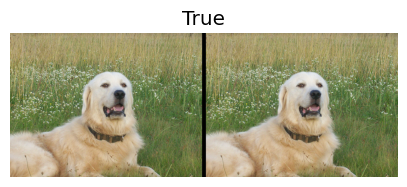

In [77]:
img = PILImage.create(files[0])
s = SiameseImage(img, img, True)
s.show();

We can also try with a second image that's not from the same class:

我们也可以尝试一个不属于同一类的第二张图片：

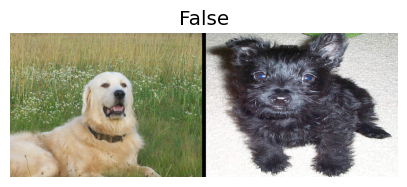

In [78]:
img1 = PILImage.create(files[1])
s1 = SiameseImage(img, img1, False)
s1.show();

The important thing with transforms that we saw before is that they dispatch over tuples or their subclasses. That's precisely why we chose to subclass `fastuple` in this instance—this way we can apply any transform that works on images to our `SiameseImage` and it will be applied on each image in the tuple:

我们之前看到的转换的重要之处是它们会分派到元组或其子类。这正是为什么在这种情况下我们选择子类化`fastuple`的原因-这样，我们可以将适用于图像的任何转换应用于我们的`SiameseImage`，并且它将应用于元组中的每个图像：

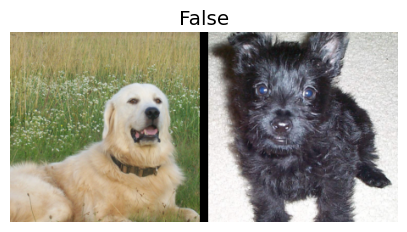

In [79]:
s2 = Resize(224)(s1)
s2.show();

Here the `Resize` transform is applied to each of the two images, but not the Boolean flag. Even if we have a custom type, we can thus benefit from all the data augmentation transforms inside the library.

We are now ready to build the `Transform` that we will use to get our data ready for a Siamese model. First, we will need a function to determine the classes of all our images:

这里`Resize`转换应用于两个图片中的每一个，但不应用于布尔标志。即使我们有一个自定义类型，我们也可以从库中的所有数据增强转换中受益。

现在我们准备构建`Transform`，以便为暹罗模型准备数据。首先，我们需要一个函数来确定所有图片的类别：

In [80]:
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

For each image our tranform will, with a probability of 0.5, draw an image from the same class and return a `SiameseImage` with a true label, or draw an image from another class and return a `SiameseImage` with a false label. This is all done in the private `_draw` function. There is one difference between the training and validation sets, which is why the transform needs to be initialized with the splits: on the training set we will make that random pick each time we read an image, whereas on the validation set we make this random pick once and for all at initialization. This way, we get more varied samples during training, but always the same validation set:

对于每张图片，我们的转换将以 0.5 的概率从同一类中绘制一张图片，并返回一个带有真标签的`SiameseImage`，或者从另一类中绘制一张图片并返回一个带有假标签的`SiameseImage`。这一切都在私有的`_draw`函数中完成。训练集和验证集之间有一个区别，这就是为什么转换需要用拆分初始化：在训练集上，我们将每次读取一张图片时进行随机选择，而在验证集上，我们将在初始化时进行一次性随机选择。这样，在训练期间我们会得到更多不同的样本，但始终是相同的验证集：

In [81]:
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(f for f in files if label_func(f) == l) 
                          for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, t)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same: 
            cls = random.choice(L(l for l in self.labels if l != cls)) 
        return random.choice(self.lbl2files[cls]),same

We can then create our main transform:

然后我们可以创建我们的主要转换：

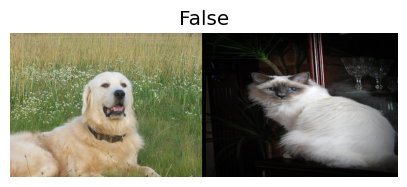

In [82]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)
tfm(files[0]).show();

In the mid-level API for data collection we have two objects that can help us apply transforms on a set of items, `TfmdLists` and `Datasets`. If you remember what we have just seen, one applies a `Pipeline` of transforms and the other applies several `Pipeline`s of transforms in parallel, to build tuples. Here, our main transform already builds the tuples, so we use `TfmdLists`:

在数据收集的中级 API 中，我们有两个对象可以帮助我们在一组项目上应用转换：`TfmdLists`和`Datasets`。如果您记得刚才看到的内容，一个应用一系列转换的`Pipeline`，另一个并行应用多个`Pipeline`，以构建元组。在这里，我们的主要转换已经构建了元组，因此我们使用`TfmdLists`：

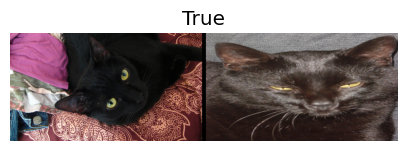

In [83]:
tls = TfmdLists(files, tfm, splits=splits)
show_at(tls.valid, 0);

And we can finally get our data in `DataLoaders` by calling the `dataloaders` method. One thing to be careful of here is that this method does not take `item_tfms` and `batch_tfms` like a `DataBlock`. The fastai `DataLoader` has several hooks that are named after events; here what we apply on the items after they are grabbed is called `after_item`, and what we apply on the batch once it's built is called `after_batch`:

最后，我们可以通过调用`dataloaders`方法在`DataLoaders`中获取我们的数据。这里需要注意的一点是，这个方法不像`DataBlock`那样接受`item_tfms`和`batch_tfms`。fastai 的`DataLoader`有几个钩子，这些钩子以事件命名；在我们抓取项目后应用的内容称为`after_item`，在构建批次后应用的内容称为`after_batch`：

In [84]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

Note that we need to pass more transforms than usual—that's because the data block API usually adds them automatically:

- `ToTensor` is the one that converts images to tensors (again, it's applied on every part of the tuple).
- `IntToFloatTensor` converts the tensor of images containing integers from 0 to 255 to a tensor of floats, and divides by 255 to make the values between 0 and 1.

请注意，我们需要传递比通常更多的转换，这是因为数据块 API 通常会自动添加它们：

-   `ToTensor`是将图像转换为张量的函数（再次，它应用于元组的每个部分）。

-   `IntToFloatTensor`将包含 0 到 255 之间整数的图像张量转换为浮点数张量，并除以 255，使值在 0 到 1 之间。

We can now train a model using this `DataLoaders`. It will need a bit more customization than the usual model provided by `vision_learner` since it has to take two images instead of one, but we will see how to create such a model and train it in <<chapter_arch_dtails>>.

现在我们可以使用这个`DataLoaders`来训练模型。与`cnn_learner`提供的通常模型相比，它需要更多的定制，因为它必须接受两个图像而不是一个，但我们将看到如何创建这样的模型并在第十五章中进行训练。

## Conclusion

fastai provides a layered API. It takes one line of code to grab the data when it's in one of the usual settings, making it easy for beginners to focus on training a model without spending too much time assembling the data. Then, the high-level data block API gives you more flexibility by allowing you to mix and match some building blocks. Underneath it, the mid-level API gives you greater flexibility to apply any transformations on your items. In your real-world problems, this is probably what you will need to use, and we hope it makes the step of data-munging as easy as possible.

fastai 提供了分层 API。当数据处于通常设置之一时，只需一行代码即可获取数据，这使得初学者可以专注于训练模型，而无需花费太多时间组装数据。然后，高级数据块 API 通过允许您混合和匹配构建块来提供更多灵活性。在其下面，中级 API 为您提供更大的灵活性，以在项目上应用转换。在您的实际问题中，这可能是您需要使用的内容，我们希望它使数据处理步骤尽可能简单。

## Questionnaire

1. Why do we say that fastai has a "layered" API? What does it mean?
1. Why does a `Transform` have a `decode` method? What does it do?
1. Why does a `Transform` have a `setup` method? What does it do?
1. How does a `Transform` work when called on a tuple?
1. Which methods do you need to implement when writing your own `Transform`?
1. Write a `Normalize` transform that fully normalizes items (subtract the mean and divide by the standard deviation of the dataset), and that can decode that behavior. Try not to peek!
1. Write a `Transform` that does the numericalization of tokenized texts (it should set its vocab automatically from the dataset seen and have a `decode` method). Look at the source code of fastai if you need help.
1. What is a `Pipeline`?
1. What is a `TfmdLists`? 
1. What is a `Datasets`? How is it different from a `TfmdLists`?
1. Why are `TfmdLists` and `Datasets` named with an "s"?
1. How can you build a `DataLoaders` from a `TfmdLists` or a `Datasets`?
1. How do you pass `item_tfms` and `batch_tfms` when building a `DataLoaders` from a `TfmdLists` or a `Datasets`?
1. What do you need to do when you want to have your custom items work with methods like `show_batch` or `show_results`?
1. Why can we easily apply fastai data augmentation transforms to the `SiamesePair` we built?

1.  为什么我们说 fastai 具有“分层”API？这是什么意思？

1.  `Transform`为什么有一个`decode`方法？它是做什么的？

1.  `Transform`为什么有一个`setup`方法？它是做什么的？

1.  当在元组上调用`Transform`时，它是如何工作的？

1.  编写自己的`Transform`时需要实现哪些方法？

1.  编写一个完全规范化项目的`Normalize`转换（减去数据集的平均值并除以标准差），并且可以解码该行为。尽量不要偷看！

1.  编写一个`Transform`，用于对标记化文本进行数字化（它应该从已见数据集自动设置其词汇，并具有`decode`方法）。如果需要帮助，请查看 fastai 的源代码。

1.  什么是`Pipeline`？

1.  什么是`TfmdLists`？

1.  什么是`Datasets`？它与`TfmdLists`有什么不同？

1.  为什么`TfmdLists`和`Datasets`带有“s”这个名字？

1.  如何从`TfmdLists`或`Datasets`构建`DataLoaders`？

1.  在从`TfmdLists`或`Datasets`构建`DataLoaders`时，如何传递`item_tfms`和`batch_tfms`？

1.  当您希望自定义项目与`show_batch`或`show_results`等方法一起使用时，您需要做什么？

1.  为什么我们可以轻松地将 fastai 数据增强转换应用于我们构建的`SiamesePair`？

### Further Research

1. Use the mid-level API to prepare the data in `DataLoaders` on your own datasets. Try this with the Pet dataset and the Adult dataset from Chapter 1.
1. Look at the Siamese tutorial in the fastai documentation to learn how to customize the behavior of `show_batch` and `show_results` for new type of items. Implement it in your own project.

## Understanding fastai's Applications: Wrap Up

Congratulations—you've completed all of the chapters in this book that cover the key practical parts of training models and using deep learning! You know how to use all of fastai's built-in applications, and how to customize them using the data block API and loss functions. You even know how to create a neural network from scratch, and train it! (And hopefully you now know some of the questions to ask to make sure your creations help improve society too.)

The knowledge you already have is enough to create full working prototypes of many types of neural network applications. More importantly, it will help you understand the capabilities and limitations of deep learning models, and how to design a system that's well adapted to them.

In the rest of this book we will be pulling apart those applications, piece by piece, to understand the foundations they are built on. This is important knowledge for a deep learning practitioner, because it is what allows you to inspect and debug models that you build and create new applications that are customized for your particular projects.